In [1]:
# TODO: https://stackoverflow.com/questions/51520189/zero-occurrences-frequency-using-value-counts-in-pandas

# Plotting

from typing import Tuple
import pandas as pd
from pandas.testing import assert_series_equal
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from seaborn import FacetGrid
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set_style('whitegrid')
sns.set_palette(reversed(sns.color_palette("Blues", 6)), 6)
mpl.rcParams['figure.dpi'] = 144
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams["figure.figsize"] = (4, 1)

percent_locator = ticker.MaxNLocator(10, steps=[1, 2, 2.5, 5, 10])

# 縦棒
def vbar(data_series: pd.Series, n: int, title: str, description: str = '', percent: bool = True):
    grid: FacetGrid = sns.catplot(data=data_series.to_frame().transpose(), kind='bar', orient='v', width=0.5, height=5, aspect=16/9, color="C0")
    figure: Figure = grid.figure
    ax = figure.axes[0]
    if percent:
        ax.yaxis.set_major_formatter(ticker.PercentFormatter())
        ax.yaxis.set_major_locator(percent_locator)
        ax.bar_label(ax.containers[0], fmt='%.1f%%', padding=4)
    figure.suptitle(title)
    figure.subplots_adjust(top=0.9, right=0.9)
    figure.text(0.98, 0.12, f"N={n}", ha='right')
    if description:
        figure.text(0.03, -0.02, description, ha='left', va='top')    
    return figure

# 横棒
def hbar(data_series: pd.Series, n: int, title: str, description: str = '', percent: bool = True):
    grid: FacetGrid = sns.catplot(data=data_series.to_frame().transpose(), kind='bar', orient='h', width=0.5, height=5, aspect=16/9, color="C0")
    figure: Figure = grid.figure
    ax = figure.axes[0]
    if percent:
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_major_locator(percent_locator)
        ax.bar_label(ax.containers[0], fmt='%.1f%%', padding=4)
    figure.suptitle(title)
    figure.subplots_adjust(top=0.9, right=0.9)
    figure.text(0.98, 0.12, f"N={n}", ha='right')
    if description:
        figure.text(0.03, -0.02, description, ha='left', va='top')    
    return figure

In [2]:
questions = pd.read_csv('./config/questions.csv', index_col=0).squeeze()

# Setup choices_df
# choices_df contains multiple candidates of choice indexed by column name
choices_df = pd.read_csv('./config/choices.csv')
col_names = questions.index.to_series()
assert_series_equal(choices_df['設問文章'], questions[questions != "タイムスタンプ"], check_names=False, check_index=False)
choices_df.index = col_names.drop(index=questions[questions == "タイムスタンプ"].index).values
choices_df['選択肢'] = choices_df['選択肢'].str.split(',')
choices_df['選択肢'].where(choices_df['選択肢'].notna(), None, inplace=True)

# NOTE: list() will be loaded as np.array()
df = pd.read_feather('out/after_coded.feather')
df.set_index('回答番号', inplace=True)
for col in choices_df[choices_df['複数回答'] == 1].index:
    df[col] = df[col].map(lambda x: x.tolist())

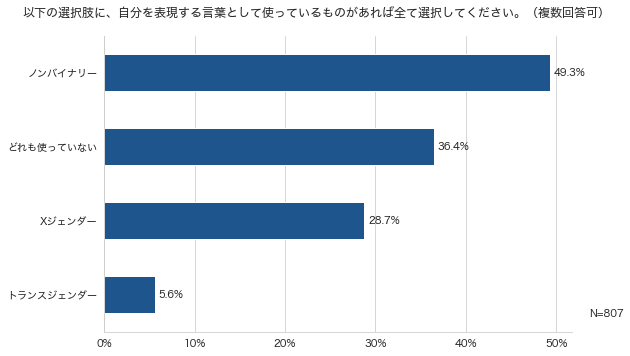

In [20]:
# 横棒
answers = df['P'][df['P'].astype(bool)] # drop empty list
n = len(answers)

answers_counts = answers.explode().value_counts() * 100 / n

hbar(answers_counts, n, questions.loc['P'])

pass

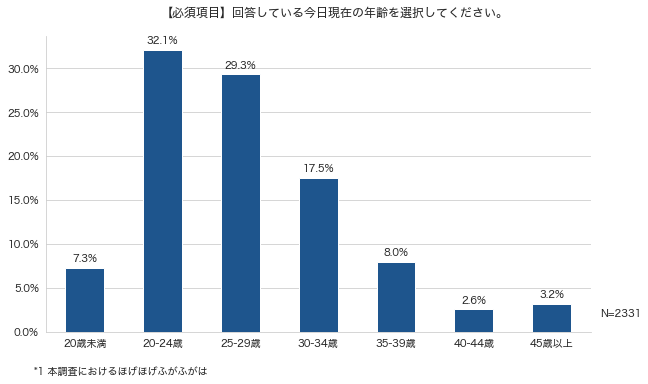

In [19]:
# 縦棒

ages = df['D'].dropna()
n = len(ages)

ages_bin = pd.cut(ages, [-1, 20, 25, 30, 35, 40, 45, 10000], labels=['20歳未満', '20-24歳', '25-29歳', '30-34歳', '35-39歳', '40-44歳', '45歳以上'], right=False)

ages_bin_count = ages_bin.value_counts(sort=False) * 100 / n

vbar(ages_bin_count, n, questions.loc['D'], description="*1 本調査におけるほげほげふがふがは")

pass

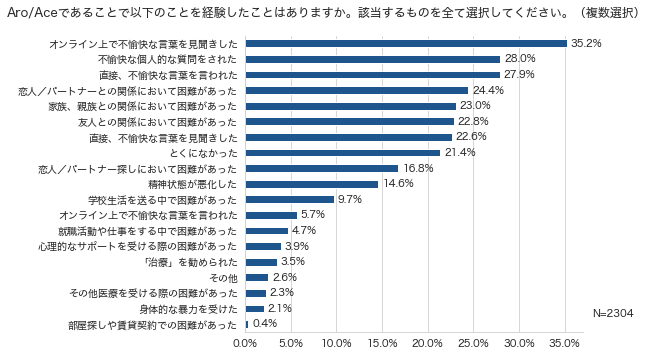

In [18]:
answers = df['CO'][df['CO'].astype(bool)]  # drop empty list
n = len(answers)

answers_counts = answers.explode().value_counts() * 100 / n

hbar(answers_counts, n, questions.loc['CO'])

pass

                         Y        S    0
0                      その他    あまりない   38
1                      その他       ある   53
2                      その他  どちらでもない    8
3                      その他       ない   29
4                      その他     ややある   62
5                 アロマンティック    あまりない  239
6                 アロマンティック       ある  114
7                 アロマンティック  どちらでもない   47
8                 アロマンティック       ない  435
9                 アロマンティック     ややある  197
10                クエスチョニング    あまりない   49
11                クエスチョニング       ある   51
12                クエスチョニング  どちらでもない   13
13                クエスチョニング       ない   37
14                クエスチョニング     ややある   71
15  グレイアロマンティック/グレイロマンティック    あまりない   53
16  グレイアロマンティック/グレイロマンティック       ある   35
17  グレイアロマンティック/グレイロマンティック  どちらでもない   16
18  グレイアロマンティック/グレイロマンティック       ない   28
19  グレイアロマンティック/グレイロマンティック     ややある   70
20               デミロマンティック    あまりない   47
21               デミロマンティック       ある   65
22               デミロマンティック  どちらでもない   10
23              

Text(0.98, 0.12, 'N=35')

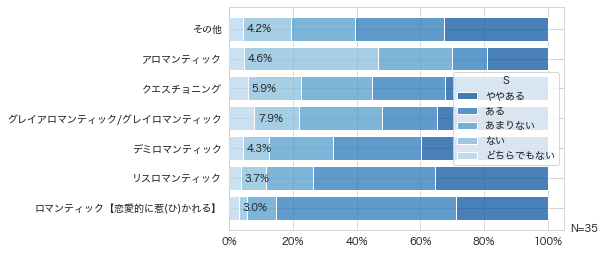

In [12]:
# 二次元

groups = df['S'].groupby(df['Y'])
counts = groups.value_counts(normalize=True).rename('count').unstack(fill_value=0).unstack(fill_value=0)
# print(counts)


# print(df.groupby('Y')['S']
#     .value_counts(normalize=True))

counts = pd.crosstab(df['S'], df['Y']).unstack().reset_index()
print(counts)


counts = (df.groupby('Y')['S']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent', copy=False)
    .reset_index()
    # .to_frame()
    # .unstack(fill_value=0)
    # .unstack(fill_value=0)
    )
print(counts)
n = len(counts)


# grid: FacetGrid = sns.histplot(data=counts, x='percent', y='Y', hue='S', kind='bar', orient='h', multiple = 'stack', color='#1C4587', width=0.5, height=5, aspect=16/9)


grid: FacetGrid = sns.histplot(
    data=counts, y='Y', hue='S', weights='percent',
    multiple='stack', shrink=0.8, discrete=True,
)


figure: Figure = grid.figure
ax = figure.axes[0]
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().set_label('')
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_locator(percent_locator)
ax.bar_label(ax.containers[0], fmt='%.1f%%', padding=4)
figure.subplots_adjust(top=0.9, right=0.9)
figure.text(0.98, 0.12, f"N={n}", ha='right')


       M    percent
0     思う  65.090284
1  わからない  19.991402
2   思わない  14.918315


Text(0.98, 0.12, 'N=35')

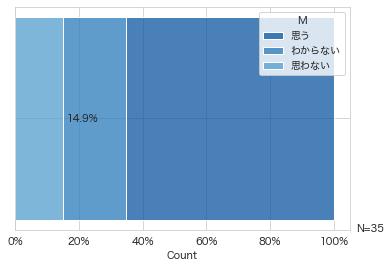

In [7]:
# 二次元

counts = (df['M']
          .value_counts(normalize=True)
          .mul(100)
          .rename_axis('M')
          .rename('percent')
          .reset_index())
print(counts)


# grid: FacetGrid = sns.histplot(data=counts, x='percent', y='Y', hue='S', kind='bar', orient='h', multiple = 'stack', color='#1C4587', width=0.5, height=5, aspect=16/9)

grid: FacetGrid = sns.histplot(
    data=counts, y=[''] * len(counts), hue='M', weights='percent',
    multiple='stack', shrink=0.8, discrete=True,
    # hue_order=counts['M'][::-1]
)

figure: Figure = grid.figure

ax = figure.axes[0]
ax.set_ylabel('')
ax.get_legend().set_label('')
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_locator(percent_locator)
ax.bar_label(ax.containers[0], fmt='%.1f%%', padding=4)
figure.subplots_adjust(top=0.9, right=0.9)
figure.text(0.98, 0.12, f"N={n}", ha='right')

# ax.legend(labels=counts['M'].unique()[::-1],
#            bbox_to_anchor=(1, 1), fontsize=8)

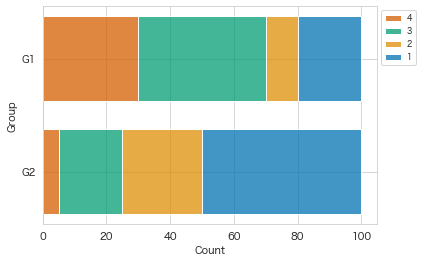

In [8]:
import numpy as np
group = np.repeat(['G1', 'G2'], 4)
value = np.array(['1', '2', '3', '4', '1', '2', '3', '4'])
percentage = np.array([20, 10, 40, 30, 50, 25, 20, 5])
stacked = pd.DataFrame(
    {'Group': group, 'Value': value, 'Percentage': percentage})

sns.histplot(stacked, y='Group', hue='Value', weights='Percentage',
             multiple='stack', palette='colorblind', shrink=0.75)
plt.legend(labels=stacked['Value'].unique()[::-1],
           bbox_to_anchor=(1, 1), fontsize=8)


In [52]:
import os

os.makedirs('out/images', 0o755, exist_ok=True)

for column in df:
    if column == 'A':
        # Skip timestamp column
        continue

    values = df[column].dropna()
    if choices_df.loc[column, '複数回答'] == 1:
        values = values[df[column].astype(bool)]  # drop empty list
    n = len(values)

    grouped = values.explode().value_counts() * 100 / n
    if len(grouped) > 50:
        print(f"column {column} has too many variations ({len(grouped)})")
        continue
    if len(grouped) == 0:
        print(f"column {column} is empty")
        continue

    if grouped.index.dtype.kind in ['i', 'u', 'f', 'c', 'm']:
        grouped.sort_index(inplace=True)
    else:
        choice_list = choices_df.loc[column, '選択肢']
        if choice_list:
            choice_series = pd.Series(choice_list)
            if not choice_series.str.isnumeric().all():
                grouped = grouped.reindex(pd.concat([choice_series, grouped.index.to_series()]).unique(), fill_value=0)
    figure = hbar(grouped, n, questions.loc[column])
    figure.savefig(f"out/images/figure-{column.rjust(2, '_')}.png", format="png", dpi=144)


/Users/ypresto/.anyenv/envs/pyenv/versions/3.10.5/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
